In [303]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio

sr = 96000
# segment_samples = 2048 
segment_samples = 8152

def gen_sine_WT():
    frequency = 440
    length = segment_samples / sr
    t_arr = np.arange(0, length, 1/sr) 
    output = np.sin(2 * np.pi * frequency * t_arr)
    return output

def crossMod(wv_1, wv_2):
    length = wv_1.size
    y = np.zeros(length)
    for i in range(length):
        interpFactor = i / length
        y[i] = (1 - interpFactor) * wv_1[i] + interpFactor * wv_2[i]
    return y

def crossMod3(wv_1, wv_2, wv_3):
    length = wv_1.size * 3
    middleBound = np.floor(length / 2).astype(int)
    y = np.zeros(length)
    for i in range(length):
        interpFactor = i / length
        if i < middleBound:
            y[i] = (1 - interpFactor) * wv_1[i] + interpFactor * wv_2[i]
        else:
            y[i] = (1 - interpFactor) * wv_2[i] + interpFactor * wv_3[i]
    return y

def crossMod4(wv_1, wv_2, wv_3):
    # we need to check that all waveforms are of the same length to avoid indexing errors and other undesirable behavior
    if not (wv_1.size == wv_2.size == wv_3.size):
        raise ValueError("All input waveforms must be of the same size.")
    
    length = wv_1.size
    middleBound = np.floor(length / 2).astype(int)
    y = np.zeros(length)
    
    # Cross-fading wv_1 to wv_2 in the first half
    # Then cross-fading wv_2 to wv_3 in the second half
    for i in range(length):
        if i < middleBound:
            interpFactor = i / middleBound  # Scale interpFactor for the first half
            y[i] = (1 - interpFactor) * wv_1[i] + interpFactor * wv_2[i]
        else:
            interpFactor = (i - middleBound) / (length - middleBound)  # Scale interpFactor for the second half
            y[i] = (1 - interpFactor) * wv_2[i] + interpFactor * wv_3[i]
    
    return y

def progressively_decimate(signal):
    npSignal = np.array(signal)
    length = signal.size

    # splitting the signal into four slices, each of which will be decimated by a greater factor
    firstBound = np.floor(length / 4).astype(int)
    secondBound = firstBound * 2
    thirdBound = firstBound * 3

    # generating the new slices and decimating by taking every nth sample, as coded by the third argument
    firstSlice = npSignal[0:firstBound:1]
    secondSlice = npSignal[firstBound:secondBound:2]
    thirdSlice = npSignal[secondBound:thirdBound:3]
    fourthSlice = npSignal[thirdBound:length:4]

    # combining all the slices into a final return array of the progressively decimated signals
    y = np.concatenate((firstSlice, secondSlice, thirdSlice, fourthSlice))

    return y

def bitCrush(signal, new_bit_depth):
    # get new bit depth
    bdepth = 2 ** new_bit_depth
    # use new bit depth to rescale the signal
    scaled_signal = np.interp(signal, (-1, 1), (0, bdepth - 1))
    # Quantize by rounding to nearest integer
    quantized_signal = np.round(scaled_signal)
    # Rescale back to the range -1 to 1
    rescaled_signal = np.interp(quantized_signal, (0, bdepth - 1), (-1, 1))
    
    return rescaled_signal


sq2 length:  8152


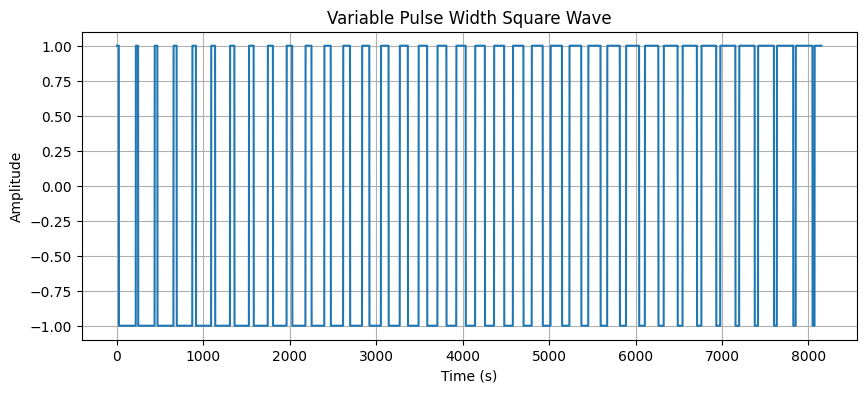

In [304]:
def variable_square():
    # again, we are generating signals for a wavetable, so frequency and duration can be hardcoded or derived from global vars
    frequency = 440
    duration = segment_samples / sr
    # here we are setting the coefficient for the duty cycles, which will determine the extremes of pulsewidth to be 
    min_duty_cycle = 0.1
    max_duty_cycle = 0.9
    t = np.linspace(0, duration, segment_samples)
    
    # Calculate the duty cycle at each sample point
    duty_cycles = np.linspace(min_duty_cycle, max_duty_cycle, segment_samples)
    
    # Period of the square wave
    period = 1 / frequency
    
    # Create the waveform array
    waveform = np.zeros(segment_samples)
    
    # Generate the waveform
    for i in range(segment_samples):
        # Current time within the period (modulus operation)
        t_mod = t[i] % period
        # Check if the current time is within the high state duration
        # this conditional will determine if we are before or after the duty cycle point, which determines whether we are outputting 1 or -1 for our amplitude value
        if t_mod < duty_cycles[i] * period:
            waveform[i] = 1
        else:
            waveform[i] = -1  # Assuming bipolar square wave (-amplitude to +amplitude)
    
    return waveform



# Generate the waveform

sq2 = variable_square()
sf.write('sq_2.wav', sq2, sr, subtype='FLOAT')
print('sq2 length: ', sq2.size)
# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(sq2, label="Variable Pulse Width Square Wave")
plt.title("Variable Pulse Width Square Wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


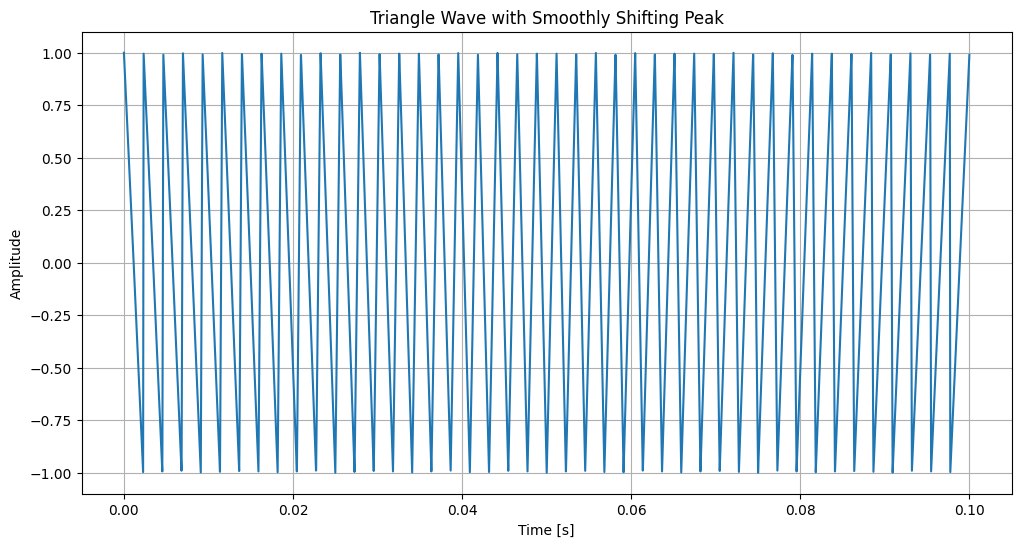

In [305]:
def variable_triangle_gen():
    # since this oscillator will be used for wavetable generation, I do not need to dynamically change frequency, duration, or amplitude, and instead hard coded them below
    frequency = 440
    duration = 0.1
    
    # here I am generating a sequence of time values that scale evenly from 0 to the duration constant I have set, which was optimized for wavetable reading in serum
    # For the length of the t array, I use the globally set segment_samples variable
    # Setting endpoint to false helps ensure full periodicity within the signal
    t = np.linspace(0, duration, segment_samples, endpoint=False)
    
    # Sets the period of the triangle wave, this will allow us to track where within the cycle we are and set up or down slopes accordingly
    period = 1 / frequency
    
    # this generates an array of zeros of the correct length, allowing us to iterate through and set the proper amplitudes for the variable triangle wave
    output = np.zeros(segment_samples)
    for i in range(segment_samples):
        # In order to calculate a value to shift the peak of the triangle wave over the course of the signal, I need a variable to track this progress through the range:
        peak_pos = t[i] / duration
        
        # The modulo of the period by the sample number will give us the current position within the current cycle
        t_mod = t[i] % period
        # now we need to tell whether we are on the rising or falling edge of the triangle wave
        # To do this, we get the sample index within this period of where the peak is located - we get this with peak_pos * period
        # once obtained, we can tell if the current location within the period, t_mod, is before or after the peak
        if t_mod < peak_pos * period:
            # Rising edge of the triangle
            output[i] = (t_mod / (peak_pos * period)) * 2 - 1
        else:
            # Falling edge of the triangle
            output[i] = ((period - t_mod) / (period - peak_pos * period)) * 2 - 1
    
    # Scale the waveform by the hardcoded amplitude
    output *= 1
    
    return output

# Example usage
duration = .1  # in seconds
sample_rate = 44100  # in Hz
frequency = 440  # in Hz, slower frequency to see the shifting peak clearly
amplitude = 1

waveform = variable_triangle_gen()
sf.write('triangle_wave.wav', waveform, sample_rate, subtype='FLOAT')

# Plot the generated waveform
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, .1, len(waveform)), waveform)
plt.title("Triangle Wave with Smoothly Shifting Peak")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [306]:
sin_1 = gen_sine_WT()
tri_1 = variable_triangle_gen()
sqr_1 = variable_square()
# crossNew = crossMod(w1, sq3)
cross3 = crossMod4(sin_1, tri_1, sqr_1)
sf.write('crossNew3.wav', cross3, sr, subtype='FLOAT')
testSine = gen_sine_WT()
sf.write('newTestSine.wav', testSine, sr, subtype='FLOAT')